In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
from functools import partial

import numpy as np
import scipy.stats as stats
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import (
    SDEFactory, BrownianBridgeProcess, OrnsteinUhlenbeckBridgeProcess
)
from neuralbridge.models.neurb import NeuralBridge
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.utils.plotting import plot_sample_path
from neuralbridge.utils.t_grid import TimeGrid

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


### Brownian bridges

In [3]:
config = read_config("../configs/brownian.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

{'sde': {'name': 'brownian', 'X_dim': 1, 'W_dim': 1, 'T': 1.0, 'dt': 0.005, 't_scheme': 'linear', 'params_X_unc': {'gamma': 1.0, 'sigma': 1.0}, 'params_X_aux': {'gamma': 0.0, 'sigma': 1.0}, 'u': [0.0], 'v': [0.0], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [20, 20, 20], 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'brownian_1.0gamma_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.001, 'batch_size': 20, 'n_iters_per_epoch': 300, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}}


In [4]:
tGrid = TimeGrid(config.sde.T, config.sde.dt, config.sde.t_scheme)
W = WienerProcess(config.sde.W_dim)

X_unc, _ = SDEFactory(config).get_sde()
neural_bridge_model = NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path_brownian = X_neu_solver.solve(
    x0=u, 
    batch_size=1000,
    training=False
)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/brownian_1.0gamma_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


In [5]:
X_cond = BrownianBridgeProcess(
    dim=config.sde.X_dim,
    params=config.sde.params_X_unc,
    T=config.sde.T,
    v=v
)
X_cond_solver = Euler(X_cond, W, tGrid)
X_cond_path_brownian = X_cond_solver.solve(x0=u, batch_size=1000)

In [6]:
def L_lower_bound_fn(gamma, sigma, T, u, v):
    return ((v - gamma * T - u)**2 - (v - u)**2) / (2 * sigma**2 * T)

def nn_gt_fn(gamma, sigma, T, v):
    return - gamma / sigma

In [7]:
gamma_lst = [1.0, 2.0, 5.0, 10.0]
L_lower_bound_lst = []
nn_gt_lst = []
for gamma in gamma_lst:
    L_lower_bound = L_lower_bound_fn(
        gamma,
        config.sde.params_X_unc.sigma,
        config.sde.T,
        u,
        v
    )
    nn_gt = nn_gt_fn(
        gamma,
        config.sde.params_X_unc.sigma,
        config.sde.T,
        v
    )
    L_lower_bound_lst.append(L_lower_bound)
    nn_gt_lst.append(nn_gt)

In [8]:
loss_lst = []
error_lst = []
path_lst = []

t_res, x_res = 100, 100
t_vals = jnp.linspace(0, 1, t_res)
x_vals = jnp.linspace(-1.5, 1.5, x_res)
t_grid, x_grid = jnp.meshgrid(t_vals, x_vals)
tx_pairs = jnp.stack([t_grid.flatten(), x_grid.flatten()], axis=1)


# Losses
def smooth(values, weight=0.8):
    smoothed = []
    last = values[0]
    for value in values:
        smoothed_value = last * weight + (1 - weight) * value
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

for gamma in gamma_lst:
    config.training.save_name = f"brownian_{gamma}gamma_tanh_linear_None_norm_0.0_dropout_adam_opt"
    neural_bridge_model = NeuralBridge(config)
    loss = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
    loss_lst.append(smooth(loss))
    X_neu = neural_bridge_model.build_neural_bridge()
    nu = partial(X_neu.nn_apply,
                 variables={},
                 training=False,
                 rngs=jax.random.PRNGKey(0))
    
    outs = jax.vmap(nu)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)
    error_lst.append(jnp.abs(outs - nn_gt_fn(gamma, config.sde.params_X_unc.sigma, config.sde.T, v)))

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/brownian_1.0gamma_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch
/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be sli

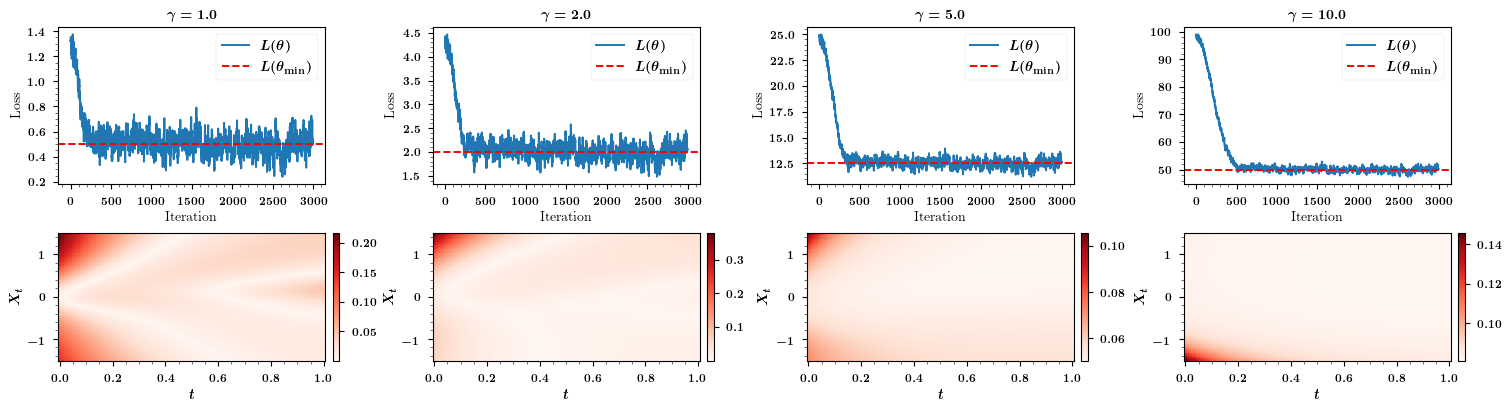

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(15, 4), gridspec_kw={'height_ratios': [0.55, 0.45]}, layout="constrained")
for i in range(4):
    axes[0, i].plot(loss_lst[i], label=r"$L(\theta)$")
    axes[0, i].set_xlabel("Iteration", fontsize=10)
    axes[0, i].set_ylabel(r"Loss", fontsize=10)
    axes[0, i].set_title(fr"$\gamma = {gamma_lst[i]}$", fontsize=10)
    axes[0, i].axhline(y=L_lower_bound_lst[i], color="red", linestyle="--", label=r'$L(\theta_{\min})$')
    axes[0, i].legend(loc="upper right", fontsize=10)
    axes[0, i].minorticks_on()
        
    im = axes[1, i].pcolormesh(t_vals, x_vals, error_lst[i], cmap="Reds")
    axes[1, i].set_xlabel(r"$t$", fontsize=10)
    axes[1, i].set_ylabel(r"$X_t$", fontsize=10)
    axes[1, i].minorticks_on()
    fig.colorbar(im, ax=axes[1, i], pad=0.0)
fig.savefig("../assets/figures/linear/brownian_loss_and_error.pdf", dpi=300, bbox_inches="tight")

### OU Bridges

In [12]:
config = read_config("../configs/ou.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

tGrid = TimeGrid(config.sde.T, config.sde.dt, config.sde.t_scheme)
W = WienerProcess(config.sde.W_dim)

X_unc, _ = SDEFactory(config).get_sde()
neural_bridge_model = NeuralBridge(config)
_ = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_neu = neural_bridge_model.build_neural_bridge()

X_neu_solver = Euler(X_neu, W, tGrid)
X_neu_path_ou = X_neu_solver.solve(
    x0=u, 
    batch_size=1000,
    training=False
)

{'sde': {'name': 'ou', 'X_dim': 1, 'W_dim': 1, 'T': 1.0, 'dt': 0.005, 't_scheme': 'linear', 'params_X_unc': {'gamma': 1.0, 'sigma': 1.0}, 'params_X_aux': {'gamma': 0.0, 'sigma': 1.0}, 'u': [0.0], 'v': [0.0], 'eps': 1e-10}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [20, 20, 20, 20], 'activation': 'tanh', 'normalization_type': None, 'dropout_rate': 0.0}, 'training': {'save_name': 'ou_1.0gamma_tanh_linear_None_norm_0.0_dropout_adam_opt', 'learning_rate': 0.001, 'batch_size': 20, 'n_iters_per_epoch': 400, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps_ratio': 0.1, 'clip_norm': 1.0}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/ou_1.0gamma_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch


In [13]:
X_cond = OrnsteinUhlenbeckBridgeProcess(
    dim=config.sde.X_dim,
    params=config.sde.params_X_unc,
    T=config.sde.T,
    v=v
)
X_cond_solver = Euler(X_cond, W, tGrid)
X_cond_path_ou = X_cond_solver.solve(x0=u, batch_size=1000)

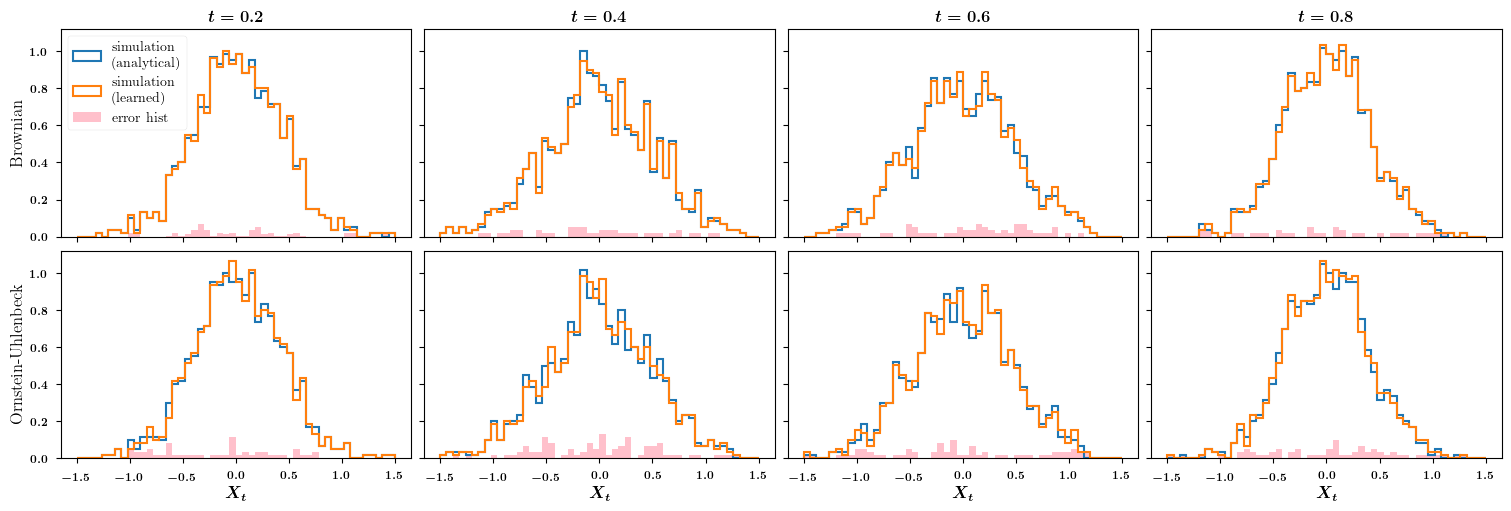

In [17]:
t_slices = [0.2, 0.4, 0.6, 0.8]
x_range = (-1.5, 1.5)
xs = jnp.linspace(x_range[0], x_range[1], 100)

fig, axes = plt.subplots(2, 4, figsize=(15, 5), sharex=True, sharey=True, layout="constrained")

for i, t_slice in enumerate(t_slices):
    t_idx = int(t_slice // config.sde.dt)
    
    # Plot histograms
    axes[0, i].hist(X_neu_path_brownian.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                  label="simulation\n(analytical)", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[0, i].hist(X_cond_path_brownian.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                 label="simulation\n(learned)", histtype='step', edgecolor='C1', linewidth=1.5)

    
    axes[0, i].set_title(fr"$t = {t_slice:.1f}$", fontsize=12)
    
    learned_hist, _ = np.histogram(X_cond_path_brownian.xs[:, t_idx, 0], bins=50, density=True, range=x_range)
    gt_hist, bin_edges = np.histogram(X_neu_path_brownian.xs[:, t_idx, 0], bins=50, density=True, range=x_range)
    
    binned_errors = np.abs(learned_hist - gt_hist)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot the binned errors
    axes[0, i].bar(bin_centers, binned_errors, width=np.diff(bin_edges),
                color='pink', label="error hist",
                bottom=0.0, fill=True)
    
    axes[1, i].hist(X_neu_path_ou.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                  label="simulation\n(analytical)", histtype='step', edgecolor='C0', linewidth=1.5)
    axes[1, i].hist(X_cond_path_ou.xs[:, t_idx, 0], bins=50, density=True, range=x_range,
                 label="simulation\n(learned)", histtype='step', edgecolor='C1', linewidth=1.5)
    
    learned_hist, _ = np.histogram(X_cond_path_ou.xs[:, t_idx, 0], bins=50, density=True, range=x_range)
    gt_hist, bin_edges = np.histogram(X_neu_path_ou.xs[:, t_idx, 0], bins=50, density=True, range=x_range)
    
    binned_errors = np.abs(learned_hist - gt_hist)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot the binned errors
    axes[1, i].bar(bin_centers, binned_errors, width=np.diff(bin_edges), label="error", color="pink",
                bottom=0.0, fill=True)
    
    axes[1, i].set_xlabel(r"$X_t$", fontsize=12)
    
axes[0, 0].set_ylabel("Brownian", fontsize=12)
axes[1, 0].set_ylabel("Ornstein-Uhlenbeck", fontsize=12)
axes[0, 0].legend(loc='upper left', fontsize=10)

fig.savefig("../assets/figures/linear/marginal_distributions.pdf", dpi=300, bbox_inches="tight")

In [14]:
def L_lower_bound_fn(gamma, sigma, T, u, v):
    a = sigma**2
    expo = jnp.exp(-gamma * T)
    log_h = 0.5 * jnp.log(gamma / (jnp.pi * a * (1 - expo**2))) - \
        (gamma / a) * ((v - u * expo)**2 / (1 - expo**2))
    log_h_tilde = 0.5 * jnp.log(1 / (2 * jnp.pi * a * T)) - \
        (v - u)**2 / (2 * a * T)
    return log_h_tilde - log_h

def nn_gt_fn(t, x, gamma, sigma, T, v):
    sinh = jnp.sinh(-gamma * (T - t))
    tanh = jnp.tanh(-gamma * (T - t))
    return (-gamma * (v / sinh - x / tanh) - (v - x) / (T - t) + gamma * x) / sigma

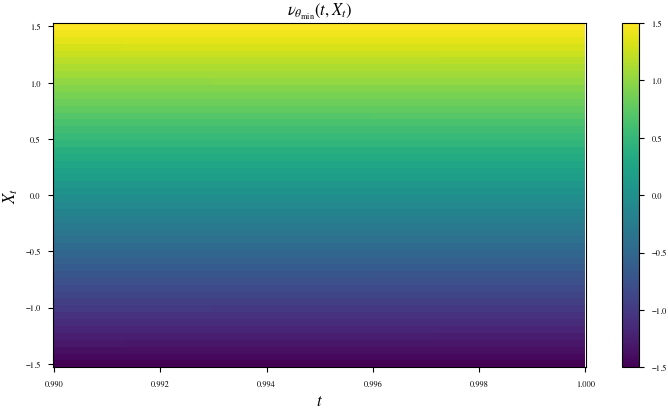

In [227]:
ts = jnp.linspace(0.99, 1.0, 500)
xs = jnp.linspace(-1.5, 1.5, 50)
t_grid, x_grid = jnp.meshgrid(ts, xs)
tx_pairs = jnp.stack([t_grid.flatten(), x_grid.flatten()], axis=1)
outs_gt = jax.vmap(nn_gt_fn, in_axes=(0, 0, None, None, None, None))(tx_pairs[:, 0], tx_pairs[:, 1:], 1.0, 1.0, 1.0, 0.0)

plt.pcolormesh(t_grid, x_grid, outs_gt.reshape(50, 500))
plt.xlabel(r"$t$", fontsize=12)
plt.ylabel(r"$X_t$", fontsize=12)
plt.title(r"$\nu_{\theta_{\min}}(t, X_t)$", fontsize=12)
plt.colorbar()
plt.savefig("../assets/figures/linear/ou_nn_gt.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
gamma_lst = [1.0, 2.0, 5.0, 10.0]
L_lower_bound_lst = []
for gamma in gamma_lst:
    L_lower_bound = L_lower_bound_fn(
        gamma,
        config.sde.params_X_unc.sigma,
        config.sde.T,
        u,
        v
    )
    L_lower_bound_lst.append(L_lower_bound)

In [16]:
loss_lst = []
error_lst = []
path_lst = []

t_res, x_res = 100, 100
t_vals = jnp.linspace(0, 1, t_res)
x_vals = jnp.linspace(-1.5, 1.5, x_res)
t_grid, x_grid = jnp.meshgrid(t_vals, x_vals)
tx_pairs = jnp.stack([t_grid.flatten(), x_grid.flatten()], axis=1)

# Losses
def smooth(values, weight=0.95):
    smoothed = []
    last = values[0]
    for value in values:
        smoothed_value = last * weight + (1 - weight) * value
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

for gamma in gamma_lst:
    config.training.save_name = f"ou_{gamma}gamma_tanh_linear_None_norm_0.0_dropout_adam_opt"
    neural_bridge_model = NeuralBridge(config)
    loss = neural_bridge_model.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
    loss_lst.append(loss)
    X_neu = neural_bridge_model.build_neural_bridge()
    nu = partial(X_neu.nn_apply,
                 variables={},
                 training=False,
                 rngs=jax.random.PRNGKey(0))
    
    nn_gt = partial(nn_gt_fn,
                    gamma=gamma,
                    sigma=config.sde.params_X_unc.sigma,
                    T=config.sde.T,
                    v=v
    )
    
    outs = jax.vmap(nu)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)
    gts = jax.vmap(nn_gt)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)
    error_lst.append(jnp.abs(outs - gts))


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/ou_1.0gamma_tanh_linear_None_norm_0.0_dropout_adam_opt
INFO:root:Loading pretrained model from the last epoch
/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly 

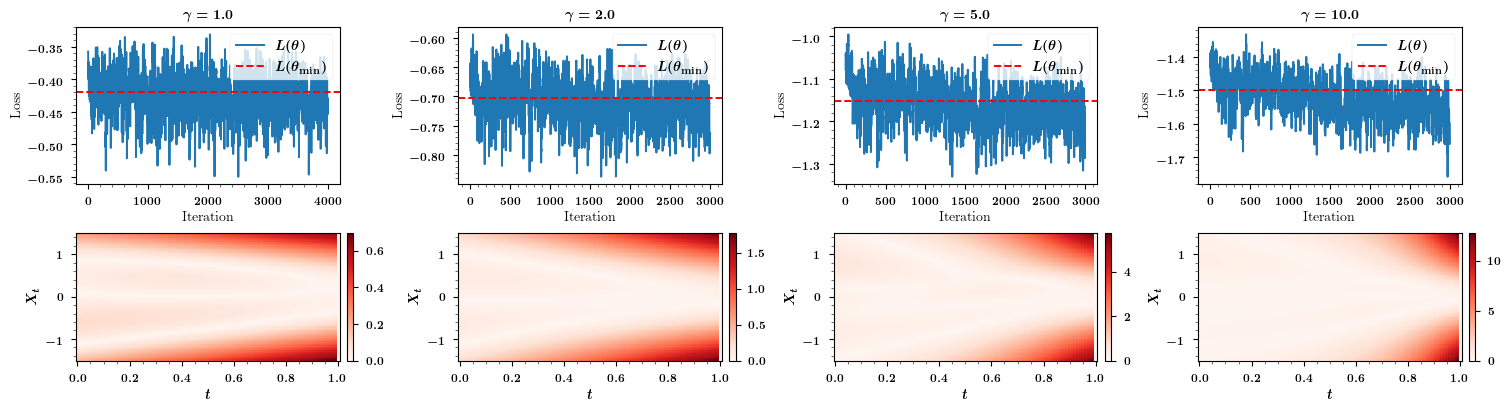

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(15, 4), gridspec_kw={'height_ratios': [0.55, 0.45]}, layout="constrained")
for i in range(4):
    axes[0, i].plot(smooth(loss_lst[i], weight=0.7), label=r"$L(\theta)$")
    axes[0, i].set_xlabel("Iteration", fontsize=10)
    axes[0, i].set_ylabel(r"Loss", fontsize=10)
    axes[0, i].set_title(fr"$\gamma = {gamma_lst[i]}$", fontsize=10)
    axes[0, i].axhline(y=L_lower_bound_lst[i], color="red", linestyle="--", label=r'$L(\theta_{\min})$')
    axes[0, i].legend(loc="upper right", fontsize=10)
    axes[0, i].minorticks_on()
    
    data = error_lst[i]
    valid_data = jnp.where(jnp.isnan(data), 0.0, data)  # Replace NaN with 0
    im = axes[1, i].pcolormesh(t_vals, x_vals, valid_data, cmap="Reds")
    axes[1, i].set_xlabel(r"$t$", fontsize=10)
    axes[1, i].set_ylabel(r"$X_t$", fontsize=10)
    axes[1, i].minorticks_on()
    fig.colorbar(im, ax=axes[1, i], pad=0.0)
fig.savefig("../assets/figures/linear/ou_loss_and_error.pdf", dpi=300, bbox_inches="tight")